# Import Modules and Data

In [1]:
# Load modules
import sys
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
from notify_run import Notify
notify = Notify()
notify.register()

Endpoint: https://notify.run/9CRUVPV2Tc5OBQpD
To subscribe, open: https://notify.run/c/9CRUVPV2Tc5OBQpD
Or scan this QR code:

                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              

In [3]:
# Load custom functions
sys.path.append('C:\\Users\\Dylan\\Desktop\\Data Science\\Projects\\DistractedDrivers\\functions')
from ddfuncs import trainsampling, cvrand

In [4]:
# Set memory limit on GPU to keep it from freezing up when fitting TensorFlow models later
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 3 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], \
                                                                [tf.config.experimental.\
                                                                 VirtualDeviceConfiguration\
                                                                 (memory_limit=1024 * 3)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Load processed training data
os.chdir('../data/processed')
df = pd.read_csv('driver_image_list_processed.csv')

In [6]:
df = trainsampling(df, samples=80, random_state=42)

In [7]:
df

,subject,classname,img,imgpath
51,p002,c0,img_13073.jpg,imgs/train/c0/img_13073.jpg
14,p002,c0,img_5585.jpg,imgs/train/c0/img_5585.jpg
71,p002,c0,img_48187.jpg,imgs/train/c0/img_48187.jpg
60,p002,c0,img_98115.jpg,imgs/train/c0/img_98115.jpg
20,p002,c0,img_66355.jpg,imgs/train/c0/img_66355.jpg
...,...,...,...,...
22364,p081,c9,img_95966.jpg,imgs/train/c9/img_95966.jpg
22404,p081,c9,img_18412.jpg,imgs/train/c9/img_18412.jpg
22415,p081,c9,img_23818.jpg,imgs/train/c9/img_23818.jpg
22358,p081,c9,img_54961.jpg,imgs/train/c9/img_54961.jpg


In [8]:
# Change to appropriate directory for data generation
os.chdir('../raw')

# Model 1 - 1 Conv, 1 MaxPool

In [9]:
model1 = Sequential()
model1.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=(256, 256, 3)))
model1.add(MaxPool2D(10))
model1.add(Flatten())
model1.add(Dense(10, activation='softmax'))
opt = Adam(learning_rate=0.0001)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6250)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                62510     
Total params: 62,790
Trainable params: 62,790
Non-trainable params: 0
_________________________________________________________________


In [10]:
model1data = cvrand(model1, 
                    df,
                    n_iterations=13,
                    batch_size=16,
                    epochs=50,
                    steps_per_epoch=115,
                    target_size=(256,256),
                    random_state=42,
                    min_delta=0.05,
                    patience=3)

CV iteration 1 of 13
Validation subjects are ['p026' 'p050' 'p002']
Found 18400 validated image filenames belonging to 10 classes.
Found 2400 validated image filenames belonging to 10 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 115 steps, validate for 75 steps
Epoch 1/50
115/115 [==============================] - 30s 262ms/step - loss: 63.9846 - accuracy: 0.1495 - val_loss: 57.7408 - val_accuracy: 0.1050
Epoch 2/50
115/115 [==============================] - 30s 260ms/step - loss: 27.8950 - accuracy: 0.2772 - val_loss: 45.9950 - val_accuracy: 0.1550
Epoch 3/50
115/115 [==============================] - 32s 278ms/step - loss: 18.5662 - accuracy: 0.3696 - val_loss: 44.0138 - val_accuracy: 0.1650
Epoch 4/50
115/115 [==============================] - 33s 287ms/step - loss: 13.2900 - accuracy: 0.4826 - val_loss: 41.8431 - val_accuracy: 0.1663
Epoch 5/50
115/115 [==============================] - 31s 270ms/step - loss: 10.8829 - accuracy: 0.5304 - val_loss: 43.3074 - 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 115 steps, validate for 75 steps
Epoch 1/50
115/115 [==============================] - 24s 208ms/step - loss: 64.2920 - accuracy: 0.1832 - val_loss: 39.9148 - val_accuracy: 0.1925
Epoch 2/50
115/115 [==============================] - 24s 207ms/step - loss: 23.2603 - accuracy: 0.2973 - val_loss: 35.9264 - val_accuracy: 0.2138
Epoch 3/50
115/115 [==============================] - 24s 207ms/step - loss: 14.9348 - accuracy: 0.4293 - val_loss: 26.7023 - val_accuracy: 0.2371
Epoch 4/50
115/115 [==============================] - 24s 208ms/step - loss: 10.4464 - accuracy: 0.5136 - val_loss: 29.2199 - val_accuracy: 0.2925
Epoch 5/50
115/115 [==============================] - 24s 208ms/step - loss: 7.7370 - accuracy: 0.5902 - val_loss: 21.0664 - val_accuracy: 0.3787
Epoch 6/50
115/115 [==============================] - 24s 209ms/step - loss: 6.1224 - accuracy: 0.6505 - val_loss: 26.4768 - val_accuracy: 0.2750 6.2754 - accuracy:  - ETA: 

115/115 [==============================] - 24s 208ms/step - loss: 21.0940 - accuracy: 0.3152 - val_loss: 48.7487 - val_accuracy: 0.1933
Epoch 3/50
115/115 [==============================] - 24s 209ms/step - loss: 13.6854 - accuracy: 0.4571 - val_loss: 38.4257 - val_accuracy: 0.1900
Epoch 4/50
115/115 [==============================] - 26s 222ms/step - loss: 10.0064 - accuracy: 0.5332 - val_loss: 29.2126 - val_accuracy: 0.2517
Epoch 5/50
115/115 [==============================] - 24s 208ms/step - loss: 7.2258 - accuracy: 0.6076 - val_loss: 33.0804 - val_accuracy: 0.1921
Epoch 6/50
115/115 [==============================] - 24s 208ms/step - loss: 6.0985 - accuracy: 0.6402 - val_loss: 24.0196 - val_accuracy: 0.2858
Epoch 7/50
115/115 [==============================] - 24s 212ms/step - loss: 4.7816 - accuracy: 0.7049 - val_loss: 24.7684 - val_accuracy: 0.2763
CV iteration 13 of 13
Validation subjects are ['p021' 'p061' 'p042']
Found 18400 validated image filenames belonging to 10 classes.


In [11]:
model1data

,iteration,sampledvalues,train_accuracies,validation_accuracy
0,1,"[p026, p050, p002]",0,0.166
1,2,"[p052, p039, p024]",1,0.337
2,3,"[p049, p064, p042]",1,0.302
3,4,"[p051, p066, p014]",0,0.205
4,5,"[p021, p045, p056]",1,0.358
5,6,"[p042, p050, p049]",1,0.358
6,7,"[p002, p049, p045]",1,0.379
7,8,"[p061, p012, p041]",1,0.334
8,9,"[p026, p049, p015]",1,0.310
9,10,"[p052, p045, p051]",1,0.355


In [ ]:
model1data.to_csv('../metrics/model1metrics.csv', index=False)

# Model 2 - Add Dropout layer

In [ ]:
model2 = Sequential()
model2.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=(256, 256, 3)))
model2.add(Dropout(0.25))
model2.add(MaxPool2D(10))
model2.add(Flatten())
model2.add(Dense(10, activation='softmax'))
opt = Adam(learning_rate=0.0001)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

In [ ]:
model2data = cvrand(model2, 
                    df,
                    n_iterations=30,
                    batch_size=16,
                    epochs=50,
                    steps_per_epoch=125,
                    target_size=(256, 256),
                    random_state=42,
                    min_delta=0.05,
                    patience=3)

In [ ]:
model2data

In [ ]:
model2data.to_csv('../metrics/model2metrics.csv', index=False)

# Model 3 - Architecture Modeled off AlexNet

In [ ]:
model3 = Sequential()
model3.add(Conv2D(99,
                 kernel_size=11,
                 strides=4,
                 padding='valid',
                 activation='relu',
                 input_shape=(227, 227, 3)))
model3.add(MaxPool2D(3,
                    strides=2,
                    padding='valid'))
model3.add(Conv2D(256,
                 kernel_size=5,
                 strides=1,
                 padding='same',
                 activation='relu'))
model3.add(MaxPool2D(3,
                    strides=2,
                    padding='valid'))
model3.add(Conv2D(384,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))
model3.add(Conv2D(384,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))
model3.add(Conv2D(256,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(10, activation='softmax'))
opt = Adam(learning_rate=0.00001)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

In [ ]:
model3data = cvrand(model3, 
                    df,
                    n_iterations=30,
                    batch_size=16,
                    epochs=50,
                    steps_per_epoch=125,
                    target_size=(227,227),
                    random_state=42,
                    min_delta=0.05,
                    patience=3)

In [ ]:
model3data

In [ ]:
model3data.to_csv('../metrics/model3metrics.csv', index=False)

In [13]:
notify.send('model 3 cv complete')

# AlexNet Corrected

In [20]:
model4 = Sequential()
model4.add(Conv2D(99,
                  kernel_size=11,
                  strides=4,
                  padding='valid',
                  input_shape=(227, 227, 3)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPool2D(3,
                     strides=2,
                     padding='valid'))
model4.add(Conv2D(256,
                  kernel_size=5,
                  strides=1,
                  padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPool2D(3,
                    strides=2,
                    padding='valid'))
model4.add(Conv2D(384,
                  kernel_size=3,
                  strides=1,
                  padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Conv2D(384,
                  kernel_size=3,
                  strides=1,
                  padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Conv2D(256,
                  kernel_size=3,
                  strides=1,
                  padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPool2D(3,
                     strides=2,
                     padding='valid'))
model4.add(Flatten())
model4.add(Dense(4096, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(4096, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(10, activation='softmax'))


Run test changing learning rate to see how model changes.
Staring with Adam, lr=0.00001

In [21]:
opt = Adam(learning_rate=0.00001)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 55, 55, 99)        36036     
_________________________________________________________________
batch_normalization_20 (Batc (None, 55, 55, 99)        396       
_________________________________________________________________
activation_20 (Activation)   (None, 55, 55, 99)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 99)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 27, 27, 256)       633856    
_________________________________________________________________
batch_normalization_21 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
activation_21 (Activation)   (None, 27, 27, 256)      

With a batch size of 16 and training set consisting of 18,400 images, performing 50 epochs of 115 steps will mean that the training data is gone over 5 times. Early stopping callback is set to 10, so if the validation accuracy does not improve 10 times in a row then the training will cease.

In [22]:
model4data = cvrand(model4, 
                    df,
                    n_iterations=13,
                    batch_size=16,
                    epochs=50,
                    steps_per_epoch=115,
                    target_size=(227,227),
                    random_state=42,
                    min_delta=0.05,
                    patience=5)

CV iteration 1 of 13
Validation subjects are ['p026' 'p050' 'p002']
Found 18400 validated image filenames belonging to 10 classes.
Found 2400 validated image filenames belonging to 10 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 115 steps, validate for 75 steps
Epoch 1/50
115/115 [==============================] - 34s 299ms/step - loss: 3.2985 - accuracy: 0.1277 - val_loss: 2.2918 - val_accuracy: 0.1000
Epoch 2/50
115/115 [==============================] - 32s 279ms/step - loss: 2.4313 - accuracy: 0.2092 - val_loss: 2.2793 - val_accuracy: 0.1554
Epoch 3/50
115/115 [==============================] - 31s 269ms/step - loss: 2.0500 - accuracy: 0.2832 - val_loss: 2.1878 - val_accuracy: 0.2071
Epoch 4/50
115/115 [==============================] - 32s 282ms/step - loss: 1.7953 - accuracy: 0.3793 - val_loss: 2.2354 - val_accuracy: 0.2075
Epoch 5/50
115/115 [==============================] - 38s 332ms/step - loss: 1.5890 - accuracy: 0.4582 - val_loss: 2.0535 - val_accura

115/115 [==============================] - 25s 217ms/step - loss: 1.2763 - accuracy: 0.5522 - val_loss: 1.5978 - val_accuracy: 0.4800
Epoch 7/50
115/115 [==============================] - 24s 209ms/step - loss: 1.1510 - accuracy: 0.6054 - val_loss: 1.5751 - val_accuracy: 0.3558
Epoch 8/50
115/115 [==============================] - 24s 213ms/step - loss: 0.9962 - accuracy: 0.6668 - val_loss: 1.3133 - val_accuracy: 0.4992
Epoch 9/50
115/115 [==============================] - 24s 211ms/step - loss: 0.8731 - accuracy: 0.7005 - val_loss: 1.3224 - val_accuracy: 0.4992
Epoch 10/50
115/115 [==============================] - 26s 225ms/step - loss: 0.7422 - accuracy: 0.7576 - val_loss: 1.4454 - val_accuracy: 0.4592
Epoch 11/50
115/115 [==============================] - 26s 227ms/step - loss: 0.6994 - accuracy: 0.7728 - val_loss: 1.2345 - val_accuracy: 0.5250
Epoch 12/50
115/115 [==============================] - 25s 214ms/step - loss: 0.5614 - accuracy: 0.8375 - val_loss: 1.2119 - val_accuracy: 

115/115 [==============================] - 24s 205ms/step - loss: 0.5989 - accuracy: 0.8054 - val_loss: 1.3020 - val_accuracy: 0.5971
Epoch 13/50
115/115 [==============================] - 23s 204ms/step - loss: 0.5249 - accuracy: 0.8375 - val_loss: 1.2161 - val_accuracy: 0.5150
Epoch 14/50
115/115 [==============================] - 23s 204ms/step - loss: 0.4554 - accuracy: 0.8582 - val_loss: 1.2226 - val_accuracy: 0.6071
Epoch 15/50
115/115 [==============================] - 23s 204ms/step - loss: 0.3943 - accuracy: 0.8799 - val_loss: 1.2442 - val_accuracy: 0.6467
Epoch 16/50
115/115 [==============================] - 25s 216ms/step - loss: 0.3451 - accuracy: 0.9000 - val_loss: 1.4473 - val_accuracy: 0.5642
Epoch 17/50
115/115 [==============================] - 25s 218ms/step - loss: 0.3064 - accuracy: 0.9125 - val_loss: 1.4569 - val_accuracy: 0.5879
CV iteration 8 of 13
Validation subjects are ['p061' 'p012' 'p041']
Found 18400 validated image filenames belonging to 10 classes.
Found

  ...
    to  
  ['...']
Train for 115 steps, validate for 75 steps
Epoch 1/50
115/115 [==============================] - 26s 223ms/step - loss: 3.3388 - accuracy: 0.1457 - val_loss: 2.1644 - val_accuracy: 0.1663
Epoch 2/50
115/115 [==============================] - 25s 220ms/step - loss: 2.3252 - accuracy: 0.2207 - val_loss: 1.9500 - val_accuracy: 0.3225
Epoch 3/50
115/115 [==============================] - 24s 211ms/step - loss: 1.9412 - accuracy: 0.3152 - val_loss: 1.6657 - val_accuracy: 0.5354
Epoch 4/50
115/115 [==============================] - 25s 215ms/step - loss: 1.7081 - accuracy: 0.4125 - val_loss: 1.6318 - val_accuracy: 0.3917
Epoch 5/50
115/115 [==============================] - 25s 219ms/step - loss: 1.4677 - accuracy: 0.4957 - val_loss: 1.3963 - val_accuracy: 0.5908
Epoch 6/50
115/115 [==============================] - 27s 231ms/step - loss: 1.3294 - accuracy: 0.5489 - val_loss: 1.3647 - val_accuracy: 0.4700
Epoch 7/50
115/115 [==============================] - 25s 220m

In [25]:
model4data

,validation_subjects,train_accuracies,validation_accuracy
0,"[p026, p050, p002]",0.801,0.395
1,"[p052, p039, p024]",0.779,0.662
2,"[p049, p064, p042]",0.846,0.669
3,"[p051, p066, p014]",0.838,0.546
4,"[p021, p045, p056]",0.834,0.576
5,"[p042, p050, p049]",0.862,0.555
6,"[p002, p049, p045]",0.880,0.647
7,"[p061, p012, p041]",0.748,0.604
8,"[p026, p049, p015]",0.897,0.609
9,"[p052, p045, p051]",0.827,0.678


In [26]:
model4data.to_csv('../metrics/model4metrics.csv', index=False)

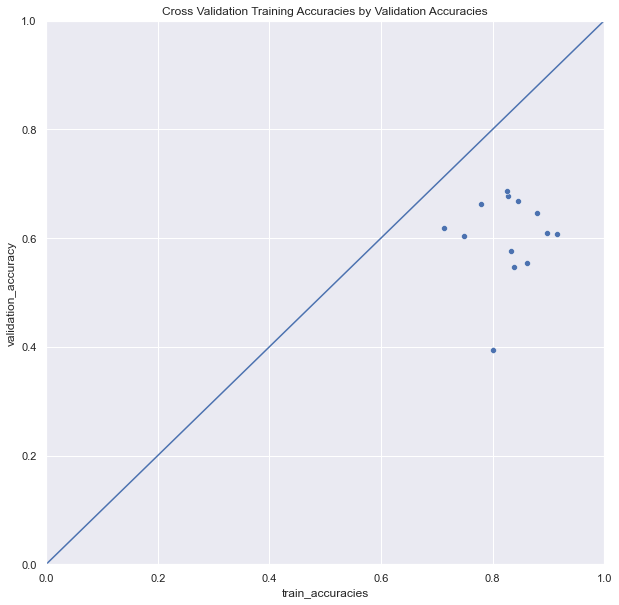

In [33]:
_ = plt.figure(figsize=(10,10))
_ = plt.xlim(0, 1)
_ = plt.ylim(0, 1)
_ = sns.scatterplot(data=model4data, x='train_accuracies', y='validation_accuracy')
_ = plt.plot([0,1], [0,1])
_ = plt.title('Cross Validation Training Accuracies by Validation Accuracies')